In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Калибровочная кривая

Сперва проанализируем полученные нами данные и оценим, хороши они или нет

In [2]:
data = pd.read_excel('group egorova 16.04.xlsx', index_col = 0)

In [3]:
data

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.290,0.319,0.321,0.350,0.383,0.400,0.412,0.437,0.443,0.423,0.479,0.095
B,0.294,0.333,0.337,0.361,0.393,0.418,0.426,0.441,0.468,0.467,0.508,0.095
C,0.288,0.320,0.342,0.342,0.364,0.392,0.409,0.443,0.459,0.464,0.507,0.098
D,0.299,0.326,0.337,0.365,0.383,0.400,0.416,0.458,0.392,0.475,0.527,0.099
E,0.303,0.328,0.341,0.356,0.390,0.408,0.421,0.456,0.475,0.485,0.500,0.101
F,0.311,0.324,0.360,0.371,0.400,0.412,0.437,0.457,0.484,0.484,0.506,0.099
G,0.348,0.333,0.354,0.376,0.395,0.405,0.432,0.442,0.477,0.482,0.515,0.098
H,0.316,0.329,0.364,0.383,0.401,0.411,0.444,0.453,0.497,0.497,0.525,0.099


In [4]:
means = []
for i in range(0, data.shape[0], 2):
    m = data.iloc[i:i+2]
    means.append(m.var(axis = 0).mean())
means = np.array(means)
print(np.argmin(means) +1)

3


In [5]:
means = []
for i in range(0, data.shape[0], 2):
    m = abs(data.iloc[i+1] - data.iloc[i])
    means.append(m.mean())
means = np.array(means)
print(np.argmin(means) +1)

3


Поздравляю, у нашей группы самые ровно раскапанные образцы (минимальный размах и дисперсия)

Отобразим все образцы на графиках (ось y -- данные спектрофотометра, x -- мкл белка)

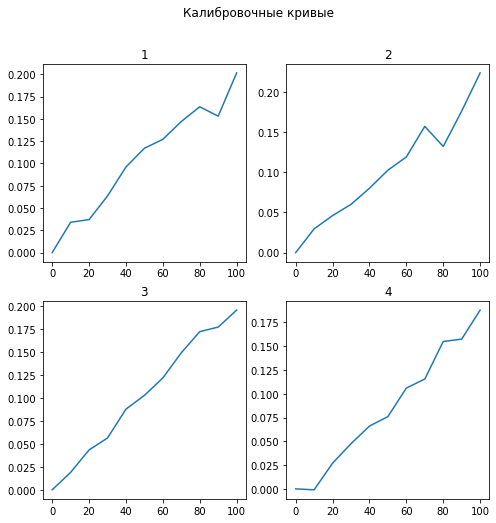

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    arr = data.iloc[[i*2,i*2+1]]
    arr = arr.mean(axis = 0)
    arr -=arr[0]
    sns.lineplot(y = arr[:-1], x = np.arange(0, 11)*10, ax = ax)
    ax.set_title(i+1)
plt.suptitle('Калибровочные кривые')
pass

И самая норм кривая

In [7]:
ours = data.loc[['E', 'F']]

In [8]:
ours = ours.mean(axis = 0)

In [9]:
ours = ours - ours[0]

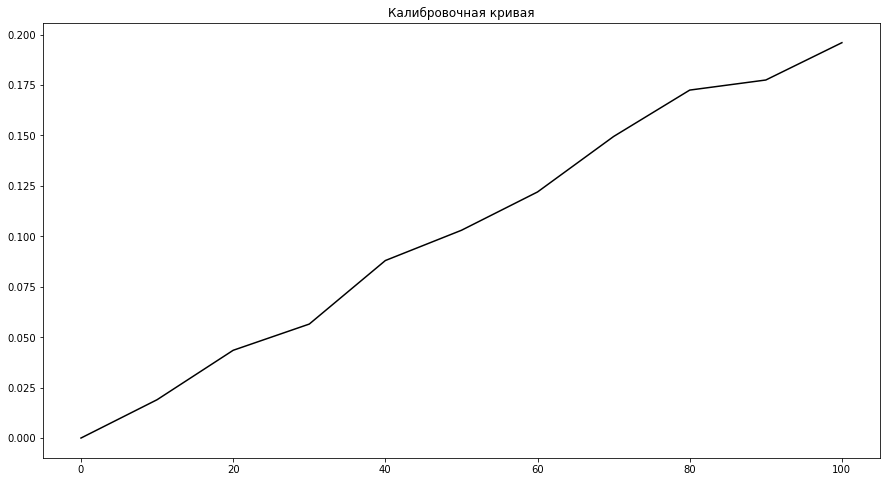

In [10]:
plt.figure(figsize=(15,8))
sns.lineplot(y = ours[:-1], x = np.arange(0, 11)*10, color = 'black').set_title('Калибровочная кривая')
pass

In [11]:
y = (np.arange(0, 11)*10)
X = ours[:-1].to_numpy().reshape(-1, 1)

Обучим линейную регрессию -- она по данным спектрофотометра будет предсказывать мкл белка. Сделаем так, чтобы bias линейной регрессии не обучался и был всегда равен нулю -- поскольку мы вычли из данных фон, при 0 мкл спектрофотометр должен показывать 0. Выведем коэффициент линейной регрессии

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
linreg = LinearRegression(fit_intercept = False)
linreg.fit(X, y)
print('Коэффициент: %f' % linreg.coef_)

Коэффициент: 488.982570


Нарисуем на одном графике калибровочную кривую, построенную при помощи линейного уравнения с полученным нами коэффициентом, и точки, измеренные нами на определенных концентрациях

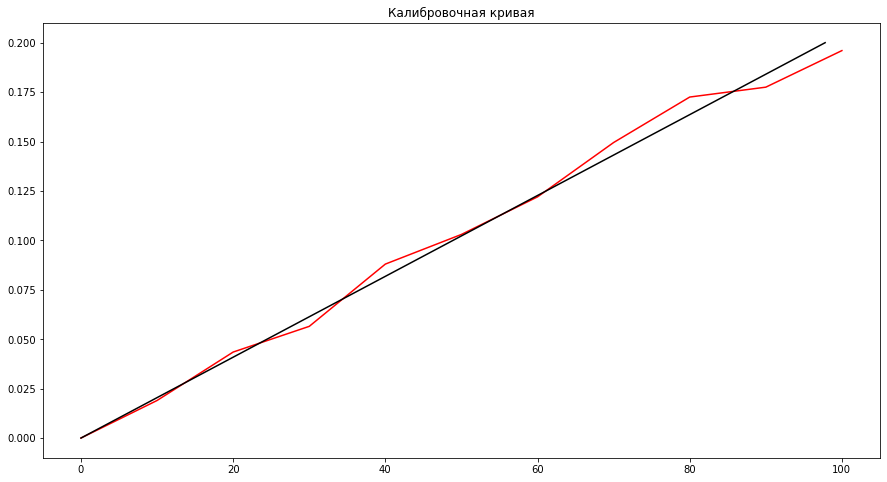

In [14]:
plt.figure(figsize=(15,8))
sns.lineplot(y = ours[:-1], x = (np.arange(0, 11)*10), color = 'red')
sns.lineplot(x = [0, 0.2*linreg.coef_[0]], y = [0, 0.2], color = 'black').set_title('Калибровочная кривая')
pass

## Концентрация белка

In [119]:
bradford = pd.read_csv('bradford.txt', sep = '\t' )

Выведем данные со спектрофотометра:

In [120]:
bradford

,1,0.5,0.25
0,0.275,0.273,0.279
1,0.290,0.288,0.300
2,0.273,0.271,0.269
3,0.277,0.284,0.278
4,0.287,0.282,0.281
5,0.298,0.291,0.294
6,0.279,0.275,0.275


План раскапывания:


                 100 мкл             50 мкл          25 мкл
20--

20(повтор)

25--

25(повтор)

30--

30(повтор)

контроль

Возьмем контроль и вычтем его из всех остальных данных

In [121]:
empty = bradford.iloc[6]
bradford.drop(6, inplace = True)

In [122]:
empty = empty.mean()
bradford = bradford- empty

Поскольку после вычитания контроля некоторые данные <0, сделаем так, чтобы они были равны 0

In [123]:
bradford[bradford<0] = 0
bradford

,1,0.5,0.25
0,0.000000,0.000000,0.002667
1,0.013667,0.011667,0.023667
2,0.000000,0.000000,0.000000
3,0.000667,0.007667,0.001667
4,0.010667,0.005667,0.004667
5,0.021667,0.014667,0.017667


Умножим все на коэффициент линейной регрессии, полученный при построении калибровочной кривой

In [124]:
bradford = bradford *(np.ones(bradford.shape[1])*linreg.coef_)
bradford

,1,0.5,0.25
0,0.000000,0.000000,1.303954
1,6.682762,5.704797,11.572587
2,0.000000,0.000000,0.000000
3,0.325988,3.748866,0.814971
4,5.215814,2.770901,2.281919
5,10.594622,7.171744,8.638692


Усредним повторы

In [128]:
bradford = bradford.rolling(2).mean()[1::2]
bradford

,1,0.5,0.25
1,3.341381,2.852398,6.438271
3,0.162994,1.874433,0.407485
5,7.905218,4.971323,5.460305


Предположим, что наши данные нормальные, а не такие, какие они есть, и что концентрация лизата прямо пропорциональна количеству белка

In [179]:
r = (bradford['1']+bradford['0.5']*2 + bradford['0.25']*4)/3
r

1    11.599753
3     1.847267
5    13.229695
dtype: float64

Учитывая концентрацию БСА 0.1 мг/мкл разделим полученные результаты на 10 -- получится концентрация в мкг/100 мкл. Умножением на 10 переведем все в мкг/мл

In [208]:
conc = np.array(r/10*10).reshape(-1, 1)
conc

array([[11.59975318],
       [ 1.84726749],
       [13.22969508]])

В таком случае:

20 -- 11.59975318 мкг/мл

25 -- 1.84726749 -> 18 мкг/мл

30 -- 13.22969508 -> 130 мкг/мл

## Протеолитическая активность

In [235]:
prot = pd.read_csv('prot.txt', sep = '\t' )
prot

,200,100,50
0,0.202,0.198,0.186
1,0.194,0.321,0.259
2,0.210,0.347,0.210
3,0.206,0.274,0.284
4,0.167,0.195,0.183
5,0.222,0.326,0.281
6,0.214,0.206,0.165


In [236]:
control = prot.iloc[6].median()
prot = (prot - control).drop(6) #убираем фон
prot = prot.rolling(2).mean()[1::2] #усредняем повторы
#prot[prot>0] = 0 можно было бы избавиться от значений больше нуля, ну глупые они, но не будем
prot

,200,100,50
1,-0.0080,0.0535,0.0165
3,0.0020,0.1045,0.0410
5,-0.0115,0.0545,0.0260


Контроль и первый образец находились в краевых лунках планшета, возможно, там больше погрешность?

В идеальной вселенной стоило бы сделать из всех трех концентраций одну колонку, но из-за того, что данные плохие, оставим все 3. Если бы данные были хорошими, все 3 итоговых результата должны оказаться равны, у нас же такого не будет. Посмотрим, что будет

In [237]:
# считаем для 1 мл
prot['200'] = prot['200']/200*1000
prot['100'] = prot['100']/100*1000
prot['50'] = prot['50']/50*1000

In [238]:
prot #для 1 мл

,200,100,50
1,-0.0400,0.535,0.33
3,0.0100,1.045,0.82
5,-0.0575,0.545,0.52


In [239]:
res = prot/conc/15 #делим /мл на мкг/мл , получая /1мкг и потом делим на время инкубации(15 минут)

In [240]:
res['i'] = [20, 25, 30]
res.set_index('i', inplace = True)

In [241]:
res

,200,100,50
i,,,
20,-0.000230,0.003075,0.001897
25,0.000361,0.037713,0.029593
30,-0.000290,0.002746,0.002620


Как говорилось, все данные должны были быть одинаковыми, но они разные. Возьмем среднее по ним

In [242]:
res.mean(axis = 1)

i
20    0.001580
25    0.022556
30    0.001692
dtype: float64

Это ответ для ед/мкг\*мин. Тогда для ед/мг*мин:

In [243]:
(res*1000).mean(axis = 1)

i
20     1.580493
25    22.555838
30     1.692321
dtype: float64

## Амилолитическая активность

Мы ставили эксперимент 2 раза, но оба раза он был неудачным из-за крахмала. Поэтому данных по нему нет(